In [2]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

'apt'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [4]:
%pip install fonts-nanum -y

Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] [-e] <vcs project url> ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] [-e] <local project path> ...
  c:\Users\user\.conda\envs\han\python.exe -m pip install [options] <archive url/path> ...

no such option: -y


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [15]:
import os
import shutil



directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            # print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            # print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [16]:
query = '0'
dataset_split(query, 210)
query = '1'
dataset_split(query, 210)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [17]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 420
테스트 데이터셋 크기: 3038
클래스: ['0', '1']


tensor([1, 0, 0, 0])
(3, 228, 906)
===input==> (228, 906, 3)


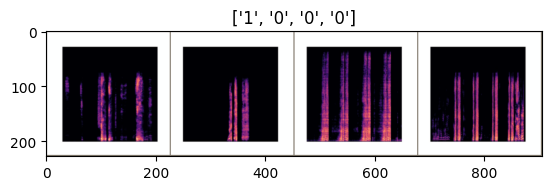

In [18]:
import matplotlib.pyplot as plt

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    print(input.numpy().shape)

    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력

    print('===input==>',input.shape)
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
print(classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [19]:
model = models.resnet34(pretrained=True)
print(model)
#for name,module in model.named_parameters():
#    module.requires_grad = False
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
for name,module in model.named_parameters():
    print( module.requires_grad )
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#stochastic gradint descent : 확률적 경사하강법
#미니배치를 사용하여 다소 부정확할수는 있지만 계산 속도가 빠르다.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.8535 Acc: 54.2857% Time: 34.6056s
#1 Loss: 0.8722 Acc: 48.8095% Time: 68.7066s
#2 Loss: 0.7514 Acc: 58.3333% Time: 103.6625s
#3 Loss: 0.9193 Acc: 54.5238% Time: 139.1055s
#4 Loss: 0.8494 Acc: 54.7619% Time: 172.1787s
#5 Loss: 0.7813 Acc: 62.6190% Time: 206.3939s
#6 Loss: 0.9715 Acc: 55.7143% Time: 240.2958s
#7 Loss: 0.7819 Acc: 58.5714% Time: 274.0986s
#8 Loss: 0.8873 Acc: 56.4286% Time: 309.5354s
#9 Loss: 0.7573 Acc: 61.1905% Time: 343.4836s
#10 Loss: 0.7231 Acc: 62.8571% Time: 377.2909s
#11 Loss: 0.9447 Acc: 57.6190% Time: 411.2326s
#12 Loss: 0.7110 Acc: 59.7619% Time: 445.0761s
#13 Loss: 0.7694 Acc: 61.1905% Time: 479.1617s
#14 Loss: 0.7775 Acc: 60.7143% Time: 512.9079s
#15 Loss: 0.8239 Acc: 63.8095% Time: 546.7969s
#16 Loss: 0.9736 Acc: 57.8571% Time: 580.9738s
#17 Loss: 0.8171 Acc: 61.9048% Time: 615.2302s
#18 Loss: 0.6533 Acc: 68.3333% Time: 649.1168s
#19 Loss: 0.7692 Acc: 61.9048% Time: 683.6177s
#20 Loss: 0.6994 Acc: 63.8095% Time: 718.2403s
#21 Loss: 0.7493 Acc: 61.

In [21]:
#모델 저장

torch.save(model.state_dict(),'model_dict.pth')
# torch.save(model,'model.pth')
torch.save(model,'model.h5')

In [22]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1]

In [ ]:
from PIL import Image


image = Image.open('test_img.jpg')
image = transforms_test(image).unsqueeze(0).to(device)
print(image.shape)
with torch.no_grad():
    outputs = model(image)
    
    _, preds = torch.max(outputs, 1)
    print(outputs)
    print(class_names[preds[0]])
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

### 저장한 모델 가져와서 쓰기

In [ ]:
from google.colab import files
files.download("model_dict.pth")

In [ ]:
files.download("model.pth")

In [ ]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model.load_state_dict(torch.load('model_dict.pth'))
model.eval()

In [ ]:
from PIL import Image
model = model.to(device)
image = Image.open('test.jpg')
image = transforms_test(image).unsqueeze(0).to(device)
print(image.shape)
with torch.no_grad():
    outputs = model(image)
    
    _, preds = torch.max(outputs, 1)
    print(outputs)
    print(class_names[preds[0]])
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])